In [2]:
import cv2
import matplotlib.pyplot as plt
# from imutils.video.webcamvideostream import WebcamVideoStream
import numpy as np
import imutils
import tensorflow as tf
import numpy as np
import cv2
from imutils.video import WebcamVideoStream
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
1.15.0


In [6]:

def find_hand_old(frame):
    img = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # gray로 변경
    YCrCb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # (Ycbcr은 색공간의 일종 Y 휘도, Cb ,Cr 은 색차성분) 피부색을 가져올때 많이사용
    # YCrCb_frame = cv2.GaussianBlur(YCrCb_frame, (9, 9), 0)
    YCrCb_frame = cv2.GaussianBlur(YCrCb_frame, (3, 3), 0) # 가우시안 블러
    # YCrCb_frame = cv2.GaussianBlur(YCrCb_frame, (1, 1), 0)
    # cv2.imshow("YCrCb_frame_old", YCrCb_frame)
    # print(frame.shape[:2])
    # mask = cv2.inRange(YCrCb_frame, np.array([0, 135, 97]), np.array([255, 177, 127]))#140 170 100 120
    # mask = cv2.inRange(YCrCb_frame, np.array([0, 133, 77]), np.array([255, 173, 127])) # best enough
    mask = cv2.inRange(YCrCb_frame, np.array([0, 127, 75]), np.array([255, 177, 130]),YCrCb_frame) # inrage 를 통해서 피부색과 근접한 색들만 검출
    bin_mask = mask # bin_mask 에 해당내용 입력

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) # getStructuringElement 커널 매트릭스 생성, MoRPH-ELLIPSE 타원 모양으로 매트릭스를 생성
    bin_mask = cv2.dilate(bin_mask, kernel, iterations=40) # dilate 이미지를 팽창 시켜준다.
    res = cv2.bitwise_or(frame, frame, mask=bin_mask) # 둘다 0이 아닌 경우만 값을 통과시킴(즉 mask가 검정색이 아닌 경우만 통과가 되기 때문에 mask영역 이외는 모두 제거된다)

    #plt.imshow("res_old", res) #cv2.imshow("res_old",res)

    return img, bin_mask, res,mask # 원본 이미지, 피부검출 mask, mask 이외 이미지

def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    bg_img = background_img.copy()
  # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    b, g, r, a = cv2.split(img_to_overlay_t)

    mask = cv2.medianBlur(a, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]

    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

  # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)

    return bg_img


# load image

In [7]:
img = cv2.imread('hand3.jpg')
image=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
overlay = cv2.imread('./image/nail2.png',cv2.IMREAD_UNCHANGED)


# main

In [8]:
import tensorflow as tf
import numpy as np
import cv2
from imutils.video import WebcamVideoStream
import find_finger as ff


args = {
    "model": "./model/export_model_008/frozen_inference_graph.pb", # 모바일에서 사용하기 위함 pb, frozen
    "labels": "./record/classes.pbtxt",
    "num_classes": 1,
    "min_confidence": 0.6,
    "class_model": "../model/saved_model/saved_model.pb"}

COLORS = np.random.uniform(0, 255, size=(args["num_classes"], 3))

if __name__ == '__main__':
    model = tf.Graph() # Graph 객체 생성

    with model.as_default():
        print("> ====== loading NAIL frozen graph into memory") # 메모리에 모델을 적용
        graphDef = tf.GraphDef() # GraphDef 파일들을 저장하고 로드하는데 사용

        with tf.gfile.GFile(args["model"], "rb") as f: # 파일 핸들을 얻는다
            serializedGraph = f.read()
            graphDef.ParseFromString(serializedGraph)
            tf.import_graph_def(graphDef, name="")
        print(">  ====== NAIL Inference graph loaded.")



    with model.as_default():
        with tf.Session(graph=model) as sess:
            imageTensor = model.get_tensor_by_name("image_tensor:0") # 기존 모델에서 불러옴
            boxesTensor = model.get_tensor_by_name("detection_boxes:0")# 기존 모델에서 불러옴
            scoresTensor = model.get_tensor_by_name("detection_scores:0")# 기존 모델에서 불러옴
            classesTensor = model.get_tensor_by_name("detection_classes:0")# 기존 모델에서 불러옴
            numDetections = model.get_tensor_by_name("num_detections:0")# 기존 모델에서 불러옴
            drawboxes = []
            # cap = cv2.VideoCapture(url)
            #vs = WebcamVideoStream(src=1)
            #vs.start()
            #while True:
            frame=image
                #frame = vs.read()
            #if frame is None:
            #    continue
            frame = cv2.flip(frame, 1) # 그림 좌우 및 상하 반전 (1은 좌우반전, 0은 상하반전)
            image = frame
            (H, W) = image.shape[:2]
            output = image.copy()
            img_ff, bin_mask, res,mask = find_hand_old(image.copy())
            image = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
            image = np.expand_dims(image, axis=0) # 차원을 늘린다.

            (boxes, scores, labels, N) = sess.run( 
                [boxesTensor, scoresTensor, classesTensor, numDetections],
                feed_dict={imageTensor: image})
            boxes = np.squeeze(boxes) # 차원을 축소해준다.
            scores = np.squeeze(scores)# 차원을 축소해준다.
            labels = np.squeeze(labels)# 차원을 축소해준다.
            boxnum = 0 
            box_mid = (0, 0)
            for (box, score, label) in zip(boxes, scores, labels): 
                    # print(int(label))
                    # if int(label) != 1:
                    #     continue
                if score < args["min_confidence"]:
                    continue
                boxnum = boxnum + 1 
                (startY, startX, endY, endX) = box # box의 값을 언패킹
                startX = int(startX * W) # 좌표와 이미지에 크기를 곱함
                startY = int(startY * H) # 좌표와 이미지에 크기를 곱함
                endX = int(endX * W)# 좌표와 이미지에 크기를 곱함
                endY = int(endY * H)# 좌표와 이미지에 크기를 곱함
                X_mid = startX + int(abs(endX - startX) / 2) #X의 중간 값을 구한다
                Y_mid = startY + int(abs(endY - startY) / 2) # y 의 중간 값을 구한다.
                nail_size =  int(((endX+endY) - (startX+startY)))
                box_mid = (X_mid, Y_mid) # 이미지의 정 중앙값
                    # draw the prediction on the output image
                label_name = 'nail'
                    # idx = int(label["id"]) - 1
                idx = 0
                
                label = "{}: {:.2f}".format(label_name, score) # 라벨을 이름과 정확도로 정리
                cv2.rectangle(output, (startX, startY), (endX, endY),
                                COLORS[idx], 2) # output 이미지에 사각형을 그린다
                cv2.circle(output,(X_mid,Y_mid),2,COLORS[idx],2)
                #cv2.circle(output,(startX,startY),2,COLORS[idx],2)
                output = overlay_transparent(output,overlay,X_mid,Y_mid-13,overlay_size=(nail_size,nail_size)) # 네일 이미지 overlay
                
                
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(output, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.3, COLORS[idx], 1) # 사각형 윗 부분에 라벨명 과 score 를 그린다.
                # show the output image
            #if box_mid == (0, 0): # 박스의 값이 0,0 일때 nothing 을 그린다.
            #    drawboxes.clear()
            #    cv2.putText(output, 'Nothing', (20, 50),
            #                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
            #elif boxnum == 1: # 박스의 값이 1일때 중앙 값을 drawboxes 에 넣고 pp 에 그 값을 넣어 원을 그린다. 이때 drawboxes가 1보다 크면 배열을 반복하여 원을 그리고 Point 라고 이미지에 적는다
            #    drawboxes.append(box_mid)
            #    if len(drawboxes) == 1:
            #        pp = drawboxes[0]
            #        cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
            #        # cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
            #    if len(drawboxes) > 1:
            #        num_p = len(drawboxes)
            #        for i in range(1, num_p):
            #            pt1 = drawboxes[i - 1]
            #            pt2 = drawboxes[i]
            #                # cv2.circle(output, pp, 0, (0, 0, 0), thickness=3)
            #            cv2.line(output, pt1, pt2, (0, 0, 0), 2, 2)
            #    cv2.putText(output, 'Point', (20, 50),
            #                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
            #else: # 둘다 아닐경우 배열 초기화 하고 Nothing 을 화면에 입력
            #    drawboxes.clear()
            #    cv2.putText(output, 'Nothing', (20, 50),
            #                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (77, 255, 9), 2)
                #plt.imshow("Output", output) # cv2.imshow("output",output)
                # cv2.waitKey(0)
            #if cv2.waitKey(1) & 0xFF == ord("q"): 
            #    cv2.destroyAllWindows()
            #    break
                    # vs.stop()

> ====== loading NAIL frozen graph into memory
>  ====== NAIL Inference graph loaded.


# result

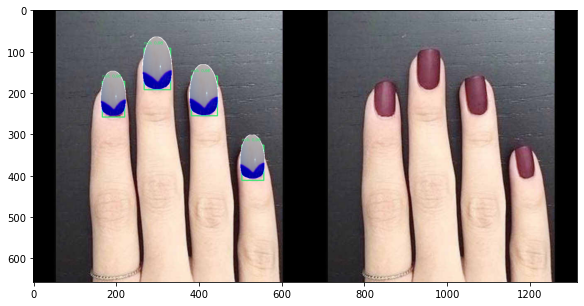

In [10]:
ori = cv2.flip(cv2.cvtColor(cv2.imread('hand3.jpg'), cv2.COLOR_BGR2RGB), 1)
fig=plt.figure(figsize=(12,5))
plt.imshow(ori)
plt.imshow(np.hstack([output,ori]))